### Machine Learning Model Development

1. Datasource:

    - https://www.kaggle.com/uciml/indian-liver-patient-records

2. Objective:

    - To classify a person into patient or non-patient based on the feature set.
    
3. Metrics:

    - For medical datasets, it is important to reduce False Negative i.e. a Patient must not be mis classified as normal.
    - In other words, typically Recall must be improved.
    
4. Scope:

    - Limited to the models used with hyperparameter tuning with few parameters and levels.(Hardware limitations)

5. Target:

    - Good balance between Recall & Precision. i.e. f1-score >= 80%
    - Difference between Train-Test Accuracy <= 5%
    
6. Recommendation from Exploratory Data Analyses (EDA)

    - Use StandardScaler.
    - Downsampling / Upsampling.
    
7. Boundary Conditions:

    1. Train-Test Split: 80-20
    2. Encoding: Non-Patient = 0 | Patient = 1
    3. Imputing: Median Imputing.
    4. Outliers Removed: Yes.
    5. Up / Down Sampling: Up sampling of minority class.
    6. Scaler: MinMax Scaler
    7. Hyperparameter Tuning Metrics: accuracy.

8. Observations:
    1. Train-Test Split with Stratification resulted in large difference in train and test accuracies. [Stratification not being persued]
    2. With upsampling of minority class, scores improved, however the difference in train and test accuracies were high. [No up / down sampling]
    3. Good balance between train, test accuracies, recall and precision is achieved using Kernel SVMs. This meets / exceeds the target.

In [1]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm

# --------------- End of sklearn libraries ---------------------

import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

import shap

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Indian_Liver_Patient_10x1.csv"
PREFIX = r"\Liver_Patient_"

# Specify number of features and targets

n_features = 10
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

# dropcol = ['Total_Protiens', 'Albumin']
# df=df.drop(columns=dropcol)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,Patient
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,Patient
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,Patient
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,Patient
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64



In [15]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

'\n    1. Cell for removing outliers.\n    2. Based on Z-score.\n'

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

List of Targets: ['Dataset']

List of Categorical Variables: ['Gender', 'Dataset']

List of Categorical Targets ['Dataset']



In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                            |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|----------------------------|---------|---------|---------|-------|-------|-------|-------|-------|
| Age                        |     583 |  44.746 |   16.19 |     4 |    33 |    45 |    58 |    90 |
| Gender                     |     583 |   0.756 |    0.43 |     0 |     1 |     1 |     1 |     1 |
| Total_Bilirubin            |     583 |   3.299 |    6.21 |   0.4 |   0.8 |     1 |   2.6 |    75 |
| Direct_Bilirubin           |     583 |   1.486 |   2.808 |   0.1 |   0.2 |   0.3 |   1.3 |  19.7 |
| Alkaline_Phosphotase       |     583 | 290.576 | 242.938 |    63 | 175.5 |   208 |   298 |  2110 |
| Alamine_Aminotransferase   |     583 |  80.714 |  182.62 |    10 |    23 |    35 |  60.5 |  2000 |
| Aspartate_Aminotransferase |     583 | 109.911 | 288.919 |    10 |    25 |    42 |    87 |  4929 |
| Total_Protiens             |     583 |   6.483 |   1.085 |   2.7 |   5.8 |   6.6 |   7.2 

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


In [20]:
# # Over Sampling

# from imblearn.over_sampling import RandomOverSampler

# y_score = y_train.iloc[:, -1].value_counts()

In [21]:
# print("****** Before Upsampling ******")

In [22]:
# y_score

In [23]:
# ros = RandomOverSampler(random_state=RND_STATE)
# X_train, y_train = ros.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

In [24]:
# print("****** After Upsampling ******")

In [25]:
# y_score

In [26]:
# Under Sampling

from imblearn.under_sampling import RandomUnderSampler

y_score = y_train.iloc[:, -1].value_counts()

In [27]:
print("****** Before Downsampling ******")

****** Before Downsampling ******


In [28]:
y_score

1    333
0    133
Name: Dataset, dtype: int64

In [29]:
rus = RandomUnderSampler(random_state=RND_STATE)
X_train, y_train = rus.fit_resample(X_train, y_train)
y_score = y_train.iloc[:, -1].value_counts()

In [30]:
print("****** After Down Sampling ******")

****** After Down Sampling ******


In [31]:
y_score

0    133
1    133
Name: Dataset, dtype: int64

In [32]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [33]:
X_train.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,13,1,0.6,0.1,320,28,56,7.2,3.6,1.00
1,50,1,5.8,3.0,661,181,285,5.7,2.3,0.67
2,60,1,0.6,0.1,186,20,21,6.2,3.3,1.10
3,56,0,0.7,0.1,145,26,23,7.0,4.0,1.30
4,22,0,1.1,0.3,138,14,21,7.0,3.8,1.10


In [34]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [35]:
X_test.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
185,38,1,1.5,0.4,298,60,103,6.0,3.0,1.0
259,42,1,30.5,14.2,285,65,130,5.2,2.1,0.6
240,48,1,0.7,0.2,165,32,30,8.0,4.0,1.0
298,31,0,1.1,0.3,190,26,15,7.9,3.8,0.9
404,22,1,0.8,0.2,198,20,26,6.8,3.9,1.3


In [36]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [37]:
y_train.head()

,Dataset
0,0
1,0
2,0
3,0
4,0


In [38]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [39]:
y_test.head()

,Dataset
185,0
259,1
240,0
298,1
404,1


In [40]:
# Scaling

# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [41]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [42]:
X_train_sc_df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.1125,1.0,0.008734,0.000000,0.109453,0.011111,0.047418,0.652174,0.658537,0.425676
1,0.5750,1.0,0.235808,0.228346,0.279104,0.105556,0.288725,0.434783,0.341463,0.202703
2,0.7000,1.0,0.008734,0.000000,0.042786,0.006173,0.010537,0.507246,0.585366,0.493243
3,0.6500,0.0,0.013100,0.000000,0.022388,0.009877,0.012645,0.623188,0.756098,0.628378
4,0.2250,0.0,0.030568,0.015748,0.018905,0.002469,0.010537,0.623188,0.707317,0.493243


In [43]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [44]:
X_test_sc_df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.4250,1.0,0.048035,0.023622,0.098507,0.030864,0.096944,0.478261,0.512195,0.425676
1,0.4750,1.0,1.314410,1.110236,0.092040,0.033951,0.125395,0.362319,0.292683,0.155405
2,0.5500,1.0,0.013100,0.007874,0.032338,0.013580,0.020021,0.768116,0.756098,0.425676
3,0.3375,0.0,0.030568,0.015748,0.044776,0.009877,0.004215,0.753623,0.707317,0.358108
4,0.2250,1.0,0.017467,0.007874,0.048756,0.006173,0.015806,0.594203,0.731707,0.628378


In [45]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10000, 1000, 100, 10, 1.0]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 1.5]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

Best: 0.720793 using {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.693895 (0.073442) with: {'C': 10000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.693895 (0.073442) with: {'C': 10000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.693895 (0.073442) with: {'C': 10000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}
0.719987 (0.065816) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.720793 (0.065513) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.719987 (0.065816) with: {'C': 10000, 'class_weight': {0: 1, 1: 1.5}, 'penalty': 'l2', 'solver': 'liblinear'}
0.696828 (0.070738) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.695873 (0.070174) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.696828 (0.070738) with: {'C': 10

In [46]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [47]:
LR_Best

{'C': 10000,
 'class_weight': {0: 1, 1: 1.5},
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [48]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [49]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [50]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [51]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.43,0.56,0.49,34.00
1,0.79,0.70,0.74,83.00
accuracy,0.66,0.66,0.66,0.66
macro avg,0.61,0.63,0.62,117.00
weighted avg,0.69,0.66,0.67,117.00


In [52]:
# Hyperparameter Tunining for Random Forest Classifier (RFC)

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1, 1.5]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

Best: 0.710690 using {'class_weight': {0: 1, 1: 1.5}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 600}
0.685978 (0.065785) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.692451 (0.070996) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 600}
0.685990 (0.061140) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}
0.688214 (0.062502) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 600}
0.698942 (0.065464) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.70236

In [53]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [54]:
RFC_Best

{'class_weight': {0: 1, 1: 1.5},
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 600}

In [55]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [56]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [57]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [58]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.47,0.65,0.54,34.00
1,0.83,0.70,0.76,83.00
accuracy,0.68,0.68,0.68,0.68
macro avg,0.65,0.67,0.65,117.00
weighted avg,0.72,0.68,0.70,117.00


In [59]:
# Hyperparameter Tunining for Extra Trees Classifier (ETC)

ETC = ExtraTreesClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1, 1.5]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=ETC, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ETC_Best = grid_search.best_params_

Best: 0.724582 using {'class_weight': {0: 1, 1: 1.5}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 600}
0.685788 (0.080174) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.685910 (0.070670) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 600}
0.683867 (0.071543) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}
0.689041 (0.075402) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 600}
0.684757 (0.070510) with: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.69261

In [60]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [61]:
ETC_Best

{'class_weight': {0: 1, 1: 1.5},
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 600}

In [62]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [63]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [64]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [65]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.47,0.65,0.54,34.00
1,0.83,0.70,0.76,83.00
accuracy,0.68,0.68,0.68,0.68
macro avg,0.65,0.67,0.65,117.00
weighted avg,0.72,0.68,0.70,117.00


In [66]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [1000, 100, 1]
gamma = [0.001, 0.01]
weights = [1, 1.5]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

Best: 0.711701 using {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.001, 'kernel': 'linear'}
0.665990 (0.062079) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.001, 'kernel': 'linear'}
0.672781 (0.056909) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.001, 'kernel': 'rbf'}
0.665990 (0.062079) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.01, 'kernel': 'linear'}
0.673224 (0.071044) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.01, 'kernel': 'rbf'}
0.711701 (0.065685) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.001, 'kernel': 'linear'}
0.695843 (0.044653) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.001, 'kernel': 'rbf'}
0.711701 (0.065685) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.01, 'kernel': 'linear'}
0.700144 (0.072505) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.01, 'kernel': 'rbf'}
0.671360 (0.076022) with: {'C': 100, 'class_weight': {0: 1, 1: 1}, 'gamma':

In [67]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [68]:
KSV_Best

{'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.001, 'kernel': 'linear'}

In [69]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [70]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [71]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [72]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.41,0.56,0.48,34.00
1,0.79,0.67,0.73,83.00
accuracy,0.64,0.64,0.64,0.64
macro avg,0.60,0.62,0.60,117.00
weighted avg,0.68,0.64,0.65,117.00


In [73]:
# Model: Hyperparameter Tuning for CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.03, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [50, 100, 150]
weights = [1, 1.5]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='F1')

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

0:	learn: 0.7192118	test: 0.6938776	best: 0.6938776 (0)	total: 142ms	remaining: 6.97s
1:	learn: 0.7281553	test: 0.7450980	best: 0.7450980 (1)	total: 143ms	remaining: 3.44s
2:	learn: 0.7227723	test: 0.7600000	best: 0.7600000 (2)	total: 144ms	remaining: 2.26s
3:	learn: 0.7128713	test: 0.7346939	best: 0.7600000 (2)	total: 145ms	remaining: 1.67s
4:	learn: 0.7128713	test: 0.7391304	best: 0.7600000 (2)	total: 146ms	remaining: 1.32s
5:	learn: 0.7263682	test: 0.7555556	best: 0.7600000 (2)	total: 148ms	remaining: 1.08s
6:	learn: 0.7263682	test: 0.7555556	best: 0.7600000 (2)	total: 149ms	remaining: 912ms
7:	learn: 0.7524752	test: 0.8000000	best: 0.8000000 (7)	total: 150ms	remaining: 785ms
8:	learn: 0.7600000	test: 0.7826087	best: 0.8000000 (7)	total: 150ms	remaining: 686ms
9:	learn: 0.7512690	test: 0.7826087	best: 0.8000000 (7)	total: 151ms	remaining: 606ms
10:	learn: 0.7474747	test: 0.8085106	best: 0.8085106 (10)	total: 152ms	remaining: 540ms
11:	learn: 0.7653061	test: 0.8260870	best: 0.8260870

In [74]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [75]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'F1',
 'depth': 4,
 'l2_leaf_reg': 1,
 'iterations': 150,
 'learning_rate': 0.1}

In [76]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

0:	learn: 0.6355140	total: 613us	remaining: 91.4ms
1:	learn: 0.6355140	total: 1.41ms	remaining: 104ms
2:	learn: 0.7125506	total: 2.01ms	remaining: 98.6ms
3:	learn: 0.7190083	total: 2.64ms	remaining: 96.3ms
4:	learn: 0.7295082	total: 3.23ms	remaining: 93.7ms
5:	learn: 0.7540984	total: 3.82ms	remaining: 91.6ms
6:	learn: 0.7333333	total: 4.4ms	remaining: 89.8ms
7:	learn: 0.7203390	total: 4.98ms	remaining: 88.4ms
8:	learn: 0.7155172	total: 5.62ms	remaining: 88ms
9:	learn: 0.7319149	total: 6.22ms	remaining: 87ms
10:	learn: 0.7288136	total: 6.91ms	remaining: 87.3ms
11:	learn: 0.7341772	total: 7.65ms	remaining: 88ms
12:	learn: 0.7394958	total: 8.47ms	remaining: 89.3ms
13:	learn: 0.7447699	total: 9.36ms	remaining: 90.9ms
14:	learn: 0.7531381	total: 10.3ms	remaining: 92.8ms
15:	learn: 0.7551867	total: 11ms	remaining: 92.4ms
16:	learn: 0.7510549	total: 11.6ms	remaining: 91.1ms
17:	learn: 0.7634855	total: 12.1ms	remaining: 89.1ms
18:	learn: 0.7685950	total: 12.7ms	remaining: 87.8ms
19:	learn: 0.7

In [77]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [78]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [79]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.42,0.71,0.53,34.00
1,0.83,0.60,0.70,83.00
accuracy,0.63,0.63,0.63,0.63
macro avg,0.63,0.65,0.61,117.00
weighted avg,0.71,0.63,0.65,117.00


In [80]:
# Artificial Neural Net (ANN) aka DNN Model

n_features = X_train.shape[1] # Get the number of features

# Single Hidden Layer ANN Definition

def ann_model(units=16, dropout_rate=0.2, learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(16, activation='relu', kernel_initializer='normal', input_shape=(n_features, )))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the Model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [81]:
# Hyperparameter Tuning

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=ann_model, epochs=30, batch_size=10, verbose=1)

# Define GridSearch Parameters

units = [10, 20, 30]
dropout_rate = [0.1, 0.2]
learn_rate = [0.001, 0.01]
momentum = [0.2, 0.4]
batch_size = [30, 60]
epochs = [30]

param_grid = dict(units=units, dropout_rate=dropout_rate, learn_rate=learn_rate, momentum=momentum, batch_size=batch_size,
                 epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
DNN_Best = grid_result.best_params_

Epoch 1/30
9/9 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5301
Epoch 2/30
9/9 [==============================] - 0s 781us/step - loss: 0.6853 - accuracy: 0.5677
Epoch 3/30
9/9 [==============================] - 0s 776us/step - loss: 0.6828 - accuracy: 0.6128
Epoch 4/30
9/9 [==============================] - 0s 997us/step - loss: 0.6758 - accuracy: 0.6391
Epoch 5/30
9/9 [==============================] - 0s 665us/step - loss: 0.6717 - accuracy: 0.6165
Epoch 6/30
9/9 [==============================] - 0s 776us/step - loss: 0.6674 - accuracy: 0.6429
Epoch 7/30
9/9 [==============================] - 0s 887us/step - loss: 0.6621 - accuracy: 0.6504
Epoch 8/30
9/9 [==============================] - 0s 776us/step - loss: 0.6557 - accuracy: 0.6729
Epoch 9/30
9/9 [==============================] - 0s 665us/step - loss: 0.6522 - accuracy: 0.6767
Epoch 10/30
9/9 [==============================] - 0s 776us/step - loss: 0.6459 - accuracy: 0.7030
Epoch 11/30
9/9 [====

In [82]:
print("------ DNN Best Parameters ------")

------ DNN Best Parameters ------


In [83]:
DNN_Best

{'batch_size': 30,
 'dropout_rate': 0.2,
 'epochs': 30,
 'learn_rate': 0.001,
 'momentum': 0.2,
 'units': 30}

In [84]:
# Get the Best ANN Parameters Using Dictionary Call

units = DNN_Best.get("units")
dropout_rate = DNN_Best.get("dropout_rate")
learn_rate = DNN_Best.get("learn_rate")
momentum = DNN_Best.get("momentum")
batch_size = DNN_Best.get("batch_size")
epochs = DNN_Best.get("epochs")

n_features = X_train.shape[1]

# define model

model = Sequential()
model.add(Dense(units=units, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# compile the model

opt= tf.keras.optimizers.Adam(learning_rate=learn_rate)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[1, 1]
TN_DNN = CM[0, 0]
FP_DNN = CM[0, 1]
FN_DNN = CM[1, 0]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

Epoch 1/30
9/9 [==============================] - 0s 2ms/step - loss: 0.6934 - binary_accuracy: 0.5038
Epoch 2/30
9/9 [==============================] - 0s 776us/step - loss: 0.6877 - binary_accuracy: 0.6090
Epoch 3/30
9/9 [==============================] - 0s 776us/step - loss: 0.6834 - binary_accuracy: 0.6278
Epoch 4/30
9/9 [==============================] - 0s 887us/step - loss: 0.6795 - binary_accuracy: 0.6165
Epoch 5/30
9/9 [==============================] - 0s 887us/step - loss: 0.6743 - binary_accuracy: 0.6316
Epoch 6/30
9/9 [==============================] - 0s 776us/step - loss: 0.6690 - binary_accuracy: 0.6579
Epoch 7/30
9/9 [==============================] - 0s 776us/step - loss: 0.6644 - binary_accuracy: 0.6617
Epoch 8/30
9/9 [==============================] - 0s 886us/step - loss: 0.6593 - binary_accuracy: 0.7030
Epoch 9/30
9/9 [==============================] - 0s 881us/step - loss: 0.6543 - binary_accuracy: 0.6955
Epoch 10/30
9/9 [==============================] - 0s 776

In [85]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [86]:
print("-------- Neural Net -------- ")

-------- Neural Net -------- 


In [87]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.29,1.00,0.45,34.00
1,0.00,0.00,0.00,83.00
accuracy,0.29,0.29,0.29,0.29
macro avg,0.15,0.50,0.23,117.00
weighted avg,0.08,0.29,0.13,117.00


In [88]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

In [89]:
print("Evaluation Summary:")

Evaluation Summary:


In [90]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC
0,Logistic_Regression,0.73,0.66,58,19,15,25,0.79,0.7,0.74,0.56,0.63
1,Random_Forest,0.88,0.68,58,22,12,25,0.83,0.7,0.76,0.65,0.67
2,Extra_Trees,0.89,0.69,58,23,11,25,0.84,0.7,0.76,0.68,0.69
3,Kernel_SVM,0.74,0.64,56,19,15,27,0.79,0.67,0.73,0.56,0.62
4,CatBoost,0.94,0.63,50,24,10,33,0.83,0.6,0.7,0.71,0.65
5,DNN,0.73,0.6,0,34,0,83,nan,0.0,nan,1.0,0.5


In [91]:
print("ROC Curve: ")

ROC Curve: 


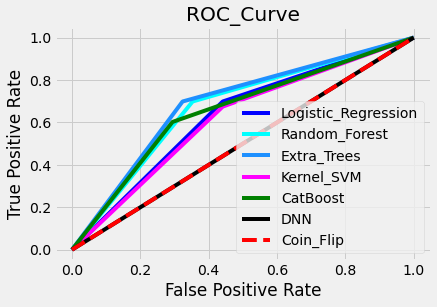

In [92]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='cyan', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='dodgerblue', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='-', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [93]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [94]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [95]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0                  0.43    0.56      0.49    34.00
           1                  0.79    0.70      0.74    83.00
           accuracy           0.66    0.66      0.66     0.66
           macro avg          0.61    0.63      0.62   117.00
           weighted avg       0.69    0.66      0.67   117.00
RFC_Rep_df 0                  0.47    0.65      0.54    34.00
           1                  0.83    0.70      0.76    83.00
           accuracy           0.68    0.68      0.68     0.68
           macro avg          0.65    0.67      0.65   117.00
           weighted avg       0.72    0.68      0.70   117.00
ETC_Rep_df 0                  0.47    0.65      0.54    34.00
           1                  0.83    0.70      0.76    83.00
           accuracy           0.68    0.68      0.68     0.68
           macro avg          0.65    0.67      0.65   117.00
           weighted avg       0.72    0.68      0.70   117.00
KSV_Rep_df 0                  0.41    0.56      0.48    34.00
           1                  0.79    0.67      0.73    83.00
           accuracy           0.64    0.64      0.64     0.64
           macro avg          0.60    0.62      0.60   117.00
           weighted avg       0.68    0.64      0.65   117.00
CBC_Rep_df 0                  0.42    0.71      0.53    34.00
           1                  0.83    0.60      0.70    83.00
           accuracy           0.63    0.63      0.63     0.63
           macro avg          0.63    0.65      0.61   117.00
           weighted avg       0.71    0.63      0.65   117.00
DNN_Rep_df 0                  0.29    1.00      0.45    34.00
           1                  0.00    0.00      0.00    83.00
           accuracy           0.29    0.29      0.29     0.29
           macro avg          0.15    0.50      0.23   117.00
           weighted avg       0.08    0.29      0.13   117.00

In [96]:
OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Summary', index=True)
writer.save()

In [97]:
explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [98]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


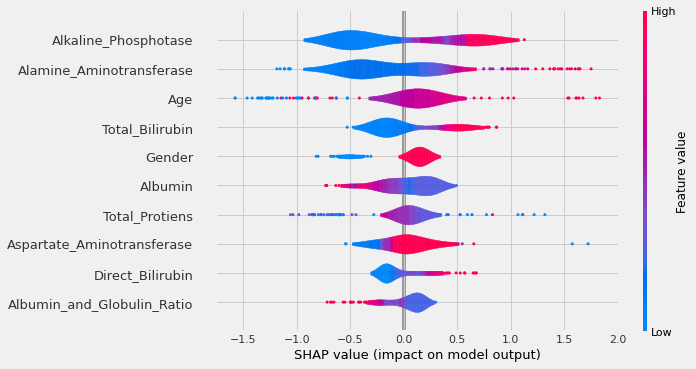

In [99]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='violin', max_display=len(featlst))

In [100]:
!jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" MLM_CLF_Dataset_Liver_Patient.ipynb --to html --no-input

[NbConvertApp] Converting notebook MLM_CLF_Dataset_Liver_Patient.ipynb to html
[NbConvertApp] Writing 608324 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\MLM_CLF_Dataset_Liver_Patient.html
